In [5]:
%matplotlib inline
from util import data_transform, group_calib_feature,sep_err_feature,get_frequencies2, plot_confidence, plot_calib
import pandas as pd
import numpy as np
import pylab
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree
import sklearn.neural_network as nn
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from statsmodels.stats import proportion
from matplotlib.ticker import MaxNLocator


In [7]:
original = pd.read_csv("BROWARD_CLEAN.csv")

In [8]:
features = list(original.columns.values)

In [9]:
keep_list=[ 'race', 'sex', 'age', 'juv_fel_count', 'juv_misd_count', 'priors_count', 
            'charge_id', 'charge_degree (misd/fel)', 'two_year_recid']
original = original[keep_list]

In [10]:
num_total = len(original)
percent_train = .8
num_train = int(percent_train*num_total)

In [11]:
num_total

7214

In [12]:
original.fillna(0)
original_train = original[:num_train]
original_test = original[num_train:]

In [13]:
labels = original['two_year_recid']
del original['two_year_recid']
data = data_transform(original)

In [14]:

train_data = data[:num_train]
train_labels = labels[:num_train]
test_data = data[num_train:]
test_labels = labels[num_train:]

In [15]:
cls = linear_model.LogisticRegression()
cls.fit(train_data, train_labels)
acc = cls.score(test_data,test_labels.as_matrix())
print(acc)

0.6874566874566874


In [16]:
cls = tree.DecisionTreeClassifier(max_depth=10)
cls.fit(train_data, train_labels)
acc = cls.score(test_data,test_labels.as_matrix())
print(acc)

0.6451836451836452


In [17]:
# neural net
cls = nn.MLPClassifier(hidden_layer_sizes=(100, ),activation='logistic')
cls.fit(train_data, train_labels)
acc = cls.score(test_data,test_labels.as_matrix())
print(acc)

0.6812196812196812


In [18]:
float(sum(train_labels))/len(train_labels)

0.44948882342748225

In [19]:
predictions = cls.predict(test_data)
scores = cls.predict_proba(test_data)[:, 1]
plt.show()
d = {'target' : test_labels.as_matrix(),
     'score' : scores,
     'prediction' : predictions}

features = ['race', 'sex', 'age', 'juv_fel_count', 'juv_misd_count', 'priors_count', 
            'charge_id', 'charge_degree (misd/fel)']
for feat in features:
    d[feat] = original_test[feat]
results = pd.DataFrame(data=d)


In [20]:
def data_feature_select(df, n_features_to_remove=0, gender=True, seed=0):
    '''Takes a subset of features'''
    # make copy
    data = df.copy()
    
    # remove group info
    if gender:
        #remove gender column
        del data["sex"]
        col_names = ['race', 'age', 'juv_fel_count', 'juv_misd_count', 'priors_count', 
            'charge_id', 'charge_degree (misd/fel)']
    else:
        #remove race column
        del data["race"]
        col_names = [ 'sex', 'age', 'juv_fel_count', 'juv_misd_count', 'priors_count', 
            'charge_id', 'charge_degree (misd/fel)']
    
    # remove n_features_to_remove features to cap model size
    if n_features_to_remove > 0:
        data.drop(col_names[0:(n_features_to_remove)],axis=1,inplace=True)
    
    return data

## Calibration plots

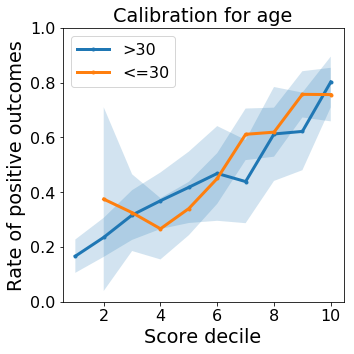

In [21]:
results.loc[results['age'] > 30, 'age'] = '>30'
results.loc[results['age'] <= 30, 'age'] = '<=30'
feat='age'
plot_calib(results, feat,num_to_plot=2, num_buckets=10,string='compasb_logistic_%s'%feat, 
           title_string="Calibration for %s"%feat, use_quantiles=True)

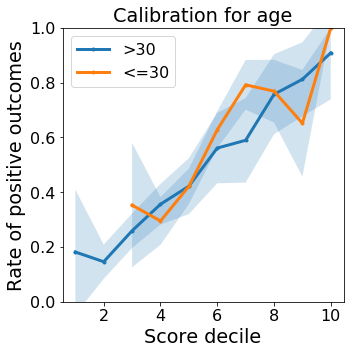

In [22]:
feat='age'
plot_calib(results, feat,num_to_plot=2, num_buckets=10,string='compasb_logistic_equalbuckets_%s'%feat, 
           title_string="Calibration for %s"%feat, use_quantiles=False)

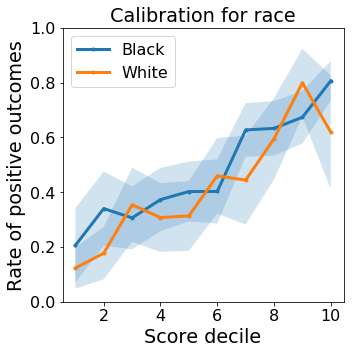

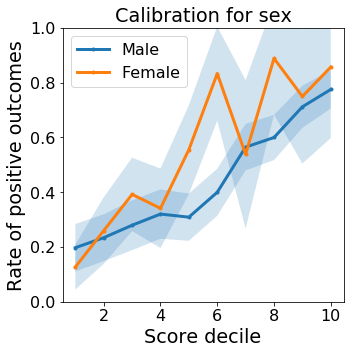

In [23]:
feat='race'
plot_calib(results, feat,num_to_plot=2, num_buckets=10,string='compasb_logistic_%s'%feat, 
           title_string="Calibration for %s"%feat, legend=['Black','White'], 
           use_quantiles=True)
feat='sex'
plot_calib(results, feat,num_to_plot=2, num_buckets=10,string='compasb_logistic_%s'%feat, 
           title_string="Calibration for %s"%feat, legend=['Male', 'Female'], 
           use_quantiles=True)

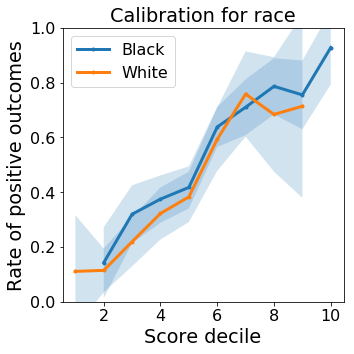

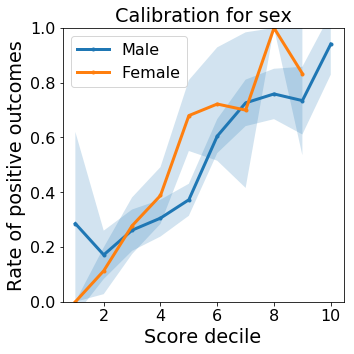

In [24]:
feat='race'
plot_calib(results, feat,num_to_plot=2, num_buckets=10,string='compasb_logistic_equalbuckets_%s'%feat, 
           title_string="Calibration for %s"%feat, legend=['Black','White'], 
           use_quantiles=False)
feat='sex'
plot_calib(results, feat,num_to_plot=2, num_buckets=10,string='compasb_logistic_equalbuckets_%s'%feat, 
           title_string="Calibration for %s"%feat, legend=['Male', 'Female'], 
           use_quantiles=False)

# Different number of training examples vs calibration

In [25]:
def one_learning_curve_expt(df, n_training_examples, gender=True, rm_group=False, return_results=True, seed=0):
    '''Runs an experiment for n_training_examples'''
    if rm_group:
        data = data_feature_select(df, 0, gender)
    else:
        data = df.copy()
    data = data_transform(data)
    
    # random training set of size n_training_examples
    np.random.seed(seed=seed)
    training_indices = np.random.choice(num_train, n_training_examples, replace=False)
    train_data = data.iloc[training_indices]
    train_labels = labels.iloc[training_indices]
    # fixed test set
    test_data = data[num_train:]
    test_labels = labels[num_train:]
        
    cls = linear_model.LogisticRegression()
    cls.fit(train_data, train_labels)
    predictions = cls.predict(test_data)
    scores = cls.predict_proba(test_data)[:, 1]

    d = {'target' : test_labels.as_matrix(),
         'score' : scores,
         'prediction' : predictions}

    features = ['race', 'sex', 'age', 'juv_fel_count', 'juv_misd_count', 'priors_count', 
            'charge_id', 'charge_degree (misd/fel)']
    for feat in features:
        d[feat] = original_test[feat]
    
    results = pd.DataFrame(data=d)
    if gender:
        calib = group_calib_feature(results, 'sex', num_buckets=8, use_quantiles=True)
        sep = sep_err_feature(results,'sex')
    else:
        calib = group_calib_feature(results, 'race', num_buckets=8, use_quantiles=True)
        sep = sep_err_feature(results, 'race')
    acc = cls.score(test_data,test_labels.as_matrix())
    score_loss = metrics.log_loss(test_labels.as_matrix(), scores)
    if return_results:
        return calib,sep, acc, score_loss, results
    else:
        return calib,sep, acc, score_loss

In [26]:
len(original)

7214

In [27]:
repeats = 20
t=30
temp = np.round(np.linspace(10, num_train, t)).astype(int)
print(temp)
t = len(temp)

maxt = 10000
#[mean, std dev]
gender = [np.zeros(t),np.zeros(t)]
race = [np.zeros(t),np.zeros(t)]
acc_g = [np.zeros(t),np.zeros(t)]
acc_r = [np.zeros(t),np.zeros(t)]
res_g = [np.zeros(t),np.zeros(t)]
res_r = [np.zeros(t),np.zeros(t)]
scorel_g = [np.zeros(t),np.zeros(t)]
scorel_r= [np.zeros(t),np.zeros(t)]
sep_g = [np.zeros(t),np.zeros(t)]
sep_r= [np.zeros(t),np.zeros(t)]


[  10  209  407  606  805 1003 1202 1401 1599 1798 1997 2195 2394 2593
 2791 2990 3188 3387 3586 3784 3983 4182 4380 4579 4778 4976 5175 5374
 5572 5771]


In [28]:
for i in range(t):
    temp_a = np.zeros(repeats)
    temp_b = np.zeros(repeats)
    temp_c = np.zeros(repeats)
    temp_d = np.zeros(repeats)
    for j in range(repeats):
        temp_a[j],temp_b[j],temp_c[j],temp_d[j] = one_learning_curve_expt(original,temp[i],gender=True,return_results=False, seed=j)
    gender[0][i] = temp_a.mean()
    sep_g[0][i] = temp_b.mean()
    acc_g[0][i] = temp_c.mean()
    scorel_g[0][i] = temp_d.mean()

    gender[1][i] = temp_a.std()
    sep_g[1][i] = temp_b.std()
    acc_g[1][i] = temp_c.std()
    scorel_g[1][i] = temp_d.std()

In [29]:
for i in range(t):
    temp_a = np.zeros(repeats)
    temp_b = np.zeros(repeats)
    temp_c = np.zeros(repeats)
    temp_d = np.zeros(repeats)
    for j in range(repeats):
        temp_a[j],temp_b[j],temp_c[j],temp_d[j] = one_learning_curve_expt(original,temp[i],gender=False,return_results=False, seed=j)
    race[0][i] = temp_a.mean()
    sep_r[0][i] = temp_b.mean()
    acc_r[0][i] = temp_c.mean()
    scorel_r[0][i] = temp_d.mean()

    race[1][i] = temp_a.std()
    sep_r[1][i] = temp_b.std()
    acc_r[1][i] = temp_c.std()
    scorel_r[1][i] = temp_d.std()   



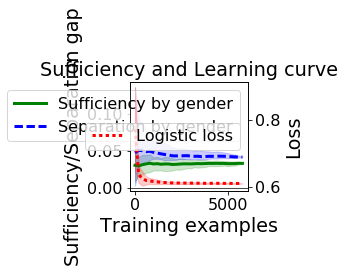

In [30]:
s = 2
fig, ax1 = plt.subplots(1, 1, figsize=(3.8, 3.2))
ax1.set_title('Sufficiency and Learning curve') 
ax1.plot(temp, gender[0], color='g', label='Sufficiency by gender')
ax1.fill_between(temp, gender[0]+s*gender[1], gender[0]-s*gender[1], alpha=.2, color='g')
ax1.plot(temp, sep_g[0], color='b', label='Separation by gender', linestyle="--")
ax1.fill_between(temp, sep_g[0]+s*sep_g[1], sep_g[0]-sep_g[1], alpha=.2, color='b')
ax1.set_ylabel('Sufficiency/Separation gap')
ax1.set_xlabel('Training examples')
ax1.axhline(y=0, color='k', linewidth=.7)
ax1.legend(loc=1)
ax2 = ax1.twinx()
ax2.plot(temp,scorel_g[0],color='r', label='Logistic loss' ,linestyle=':')
ax2.fill_between(temp,scorel_g[0]+s*scorel_g[1], scorel_g[0]-s*scorel_g[1],color='r',alpha=.2 )
ax2.set_ylabel('Loss')
ax2.legend(loc=7)
plt.tight_layout()

plt.savefig('../figures/compas2_quantiles_calibration_gender_learningcurve_loss_errbar_maxn%d.svg'%maxt)
plt.savefig('../figures/compas2_quantiles_calibration_gender_learningcurve_loss_errbar_maxn%d.pdf'%maxt)
plt.show()
plt.gcf().clear() 
plt.close()

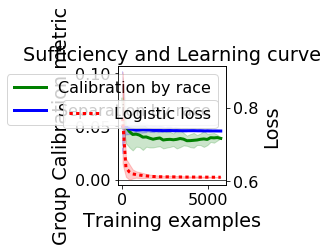

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(3.8, 3.2))
ax1.set_title('Sufficiency and Learning curve') 
ax1.plot(temp, race[0], color='g', label='Calibration by race')
ax1.fill_between(temp, race[0]+s*race[1], race[0]-s*race[1], alpha=.2, color='g')
ax1.plot(temp, sep_r[0], color='b', label='Separation by race')
ax1.fill_between(temp, sep_r[0]+s*sep_r[1], sep_r[0]-sep_r[1], alpha=.2, color='b', linestyle="--")
ax1.set_ylabel('Group Calibration metric')
ax1.set_xlabel('Training examples')
ax1.axhline(y=0, color='k', linewidth=.7)

ax1.legend(loc=1)
ax2 = ax1.twinx()
ax2.plot(temp,scorel_r[0],color='r', label='Logistic loss' , linestyle=':')
ax2.fill_between(temp,scorel_r[0]+s*scorel_r[1], scorel_r[0]-s*scorel_r[1],color='r',alpha=.2 )
ax2.set_ylabel('Loss')
ax2.legend(loc=7, bbox_to_anchor=(1, 0.6))
plt.tight_layout()
plt.savefig('../figures/compas2_quantiles_calibration_race_learningcurve_loss_errbar_maxn%d.svg'%maxt)
plt.savefig('../figures/compas2_quantiles_calibration_race_learningcurve_loss_errbar_maxn%d.pdf'%maxt)
plt.show()
plt.gcf().clear() 
plt.close()